In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import os
import glob
import numpy as np
from tqdm import auto as tqdm
from matplotlib import pylab as plt
from transformers import pipeline
from sklearn.metrics import confusion_matrix
import torch
sns.set(font_scale=1.5)
print('Cuda:', torch.cuda.is_available())
print('pwd', os.getcwd())

Cuda: True
pwd /data/home/vzhong/projects/alex-project


In [2]:
# download dataset
ddata = 'eec'
if not os.path.isdir(ddata):
    !wget https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip -O eec.zip;
    !unzip -d eec eec.zip;
df = pd.read_csv('eec/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
df.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


In [3]:
# remove nans
df = df.dropna(subset=['Emotion'])
print('# examples:', len(df))

# what are the labels?
emotions = df.Emotion.unique().tolist()
emotions

# examples: 8400


['anger', 'sadness', 'fear', 'joy']

In [12]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', device=0)
candidate_labels = emotions

In [34]:
from sklearn.metrics import f1_score
import warnings

batch_size = 30
total = len(df)
verbose = False

preds = []
golds = []
bar = tqdm.tqdm(df.iloc, total=total)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for row in bar:
        if len(golds) >= total:
            break
        hypothesis_template = row.Person + " feels {}."
        out = classifier(row.Sentence, emotions, hypothesis_template=hypothesis_template)
        preds.append(out['labels'][0])
        golds.append(row.Emotion)
        bar.set_description('f1 = {}'.format(f1_score(golds, preds, average='micro')))
        if verbose:
            print(out, preds[-1])
bar.close()

  0%|          | 0/8400 [00:00<?, ?it/s]

In [35]:
set(preds)

{'anger', 'fear', 'joy', 'sadness'}

<AxesSubplot:xlabel='pred', ylabel='gold'>

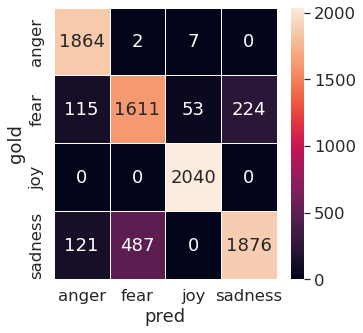

In [38]:
# plot confusion matrix
cf_df = pd.DataFrame([dict(pred=p, gold=g) for p, g in zip(golds, preds)])
cf_matrix = pd.crosstab(cf_df.gold, cf_df.pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')